In [5]:
# initial setup for the pandas-ta library 

pip install pandas-ta plotly

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import pandas_ta as ta
import plotly.graph_objects as go

### 1) Load the data from the CSV file

In [21]:
# thing to take note - the CSV file is in the same folder with with jupyter notebook
df_csv = pd.read_csv('stockprice.csv', parse_dates=['Date'], dayfirst=True)
df_csv = df_csv.set_index('Date')

# Sort the data from oldest to newest (True = oldest to newest) (False = newest to oldest)
df_csv = df_csv.sort_index(ascending=True) 

# renaming colums for easier access
df_csv.rename(columns={
    'Price': 'close',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Vol': 'volume'
}, inplace=True)

print(df_csv)

             close    open    high     low     Vol. Change %
Date                                                        
2025-08-20  226.01  229.98  230.47  225.77   42.26M   -1.97%
2025-08-19  230.56  231.27  232.87  229.35   39.40M   -0.14%
2025-08-18  230.89  231.70  233.12  230.11   37.48M   -0.30%
2025-08-15  231.59  234.00  234.28  229.34   56.04M   -0.51%
2025-08-14  232.78  234.05  235.12  230.85   51.92M   -0.24%
...            ...     ...     ...     ...      ...      ...
2008-01-08    6.12    6.43    6.52    6.10    1.52B   -3.47%
2008-01-07    6.34    6.47    6.56    6.08    2.07B   -1.40%
2008-01-04    6.43    6.84    6.89    6.39    1.46B   -7.61%
2008-01-03    6.96    6.98    7.05    6.88  842.07M    0.00%
2008-01-02    6.96    7.12    7.15    6.88    1.08B   -1.56%

[4438 rows x 6 columns]


### 2) Calculate the MACD Indicators using pandas_ta

#### Explanation of the code

close='close': This tells the function which column to use for its calculations. The MACD is almost always calculated using the closing price of each period, which you've conveniently named 'close'.

fast=12: This sets the period for the "fast" Exponential Moving Average (EMA). An EMA is a type of moving average that gives more weight to recent prices, making it more responsive to new information. The default value of 12 periods is a historical standard, typically representing about two and a half weeks of trading on a daily chart.

slow=26: This sets the period for the "slow" EMA. The core of the MACD calculation is the difference between this slow-moving average and the fast one. The default of 26 periods represents roughly one month of trading.

signal=9: This sets the period for the "signal line." The signal line is an EMA of the main MACD line itself. The crossover between the main MACD line and this smoother signal line is what generates your buy and sell signals. The 9-period default represents about two weeks of trading.

append=True: This is a convenient command that tells the function to add the results of its calculation as new columns directly to your existing df_csv DataFrame. Without this, you would have to manually create and assign the new columns.

df_csv.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

### Generating Trading Signals

A "BUY' signal - when the MACD line crossess above the signal line.
A "SELL" signal - when the MACD line crossess below the signal line.

#### Buy Signal 

1) df_csv['signal'] = 0: This is setup step. i create a new column named signal in the DataFrame. Then initialize every single row in this column with the value 0. This 0 represents a "hold" or "do nothing" instruction. This is a crucial step because I want the default action to be no action at all; signals should be the exception, not the rule.

2) buy_signal_condition: Here, i am defining the exact criteria for a "buy" signal. This is a boolean check, meaning it will evaluate to either True or False for each day (each row) in my data.

3) (df_csv['MACD_12_26_9'].shift(1) < df_csv['MACDs_12_26_9'].shift(1)): This is the first half of the condition. The .shift(1) function looks at the data from the previous day. So, this code checks: "Was yesterday's MACD line value less than yesterday's signal line value?"

4) This is the logical "AND" operator. It means both the condition before it and the condition after it must be True for the entire line to be True.

5) (df_csv['MACD_12_26_9'] > df_csv['MACDs_12_26_9']): This is the second half. It checks the data for the current day. "Is today's MACD line value greater than today's signal line value?"

The Result: The buy_signal_condition will only be True for the single, specific day where the MACD line crossed from being below the signal line to above it.

#### Sell Signal

1) sell_signal_condition: This is the exact inverse of the buy condition.

2) It checks: "Was yesterday's MACD line greater than yesterday's signal line, AND is today's MACD line less than today's signal line?"

3) This condition will only be True for the specific day a "death cross" occurs, where the MACD line crosses from above to below the signal line.

In [53]:
# Create a column to hold signals ( 1 for buy, -1 for sell and 0 for hold

# default signal
df_csv['signal'] = 0 

# Condition for a buy signal when MACD is below 1 day before and above on today pricing
# Correct logic for a buy signal
buy_signal_condition = (df_csv['MACD_12_26_9'].shift(1) < df_csv['MACDs_12_26_9'].shift(1)) & \
                       (df_csv['MACD_12_26_9'] > df_csv['MACDs_12_26_9'])

# Condition for a sell signal when MACD is above 1 day before and below on today pricing
sell_signal_condition = (df_csv['MACD_12_26_9'].shift(1) > df_csv['MACDs_12_26_9'].shift(1)) & \
                        (df_csv['MACD_12_26_9'] < df_csv['MACDs_12_26_9'])

df_csv.loc[buy_signal_condition, 'signal'] = 1
df_csv.loc[sell_signal_condition, 'signal'] = -1                                                                                             

### Create the Plot

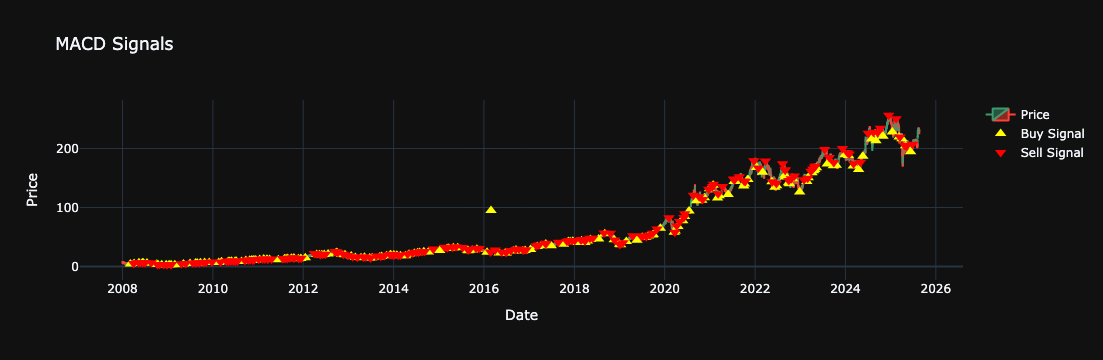

In [90]:
# Create the main candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x = df_csv.index,
    open = df_csv['open'],
    high = df_csv['high'],
    low = df_csv['low'],
    close = df_csv['close'],
    name = 'Price'
)])

# Add green up arrows for buy signals
fig.add_trace(go.Scatter(
    x = df_csv[df_csv['signal'] == 1].index,
    y = df_csv[df_csv['signal'] == 1]['low'] * 0.98, #Place marker slightly below the candle
    mode = 'markers',
    marker_symbol = 'triangle-up',
    marker_color = 'yellow',
    marker_size = 10,
    name = 'Buy Signal'
))

# Add red down arrows for sell signals
fig.add_trace(go.Scatter(
    x = df_csv[df_csv['signal'] == -1].index,
    y = df_csv[df_csv['signal'] == -1]['high'] * 1.02, # Place marker slightly above the candle
    mode = 'markers',
    marker_symbol = 'triangle-down',
    marker_color = 'red',
    marker_size = 10,
    name = 'Sell Signal'
))

# Customise the chart's appearance
fig.update_layout(
    title = 'MACD Signals',
    xaxis_title = 'Date',
    yaxis_title = 'Price',
    xaxis_rangeslider_visible = False,
    template = 'plotly_dark'
)

# Display the chart
fig.show()

# Option to save the chart in to interactive HTML File
fig.write_html('macd_chart.html')